# Problem Statement - Predict Credit card fraud transactions in an imbalanced dataset including transactions of 2 days. The different steps performed below are described here:
**Step 1 - Data understanding<br>
Step 2 - Data Visualization and Cleaning<br>
Step 3 - Train-Test Split<br>
Step 4 - Data Transformation (Power transformation using yeo-johnson transformation)<br>
Step 5 - Model building with imbalanced data<br>
            =>  Logistic Regression<br>
            =>  Decision Tree Classifier<br>
            =>  Random Forest Classifier<br>
            =>  XGBoost Classifier<br>
            =>  SVM<br>
Step 6 - Model building with data balancing technique - Random Oversampling<br>
            => Logistic Regression<br>
            => SVM<br>
            => XGBoost Classifier<br>
Step 7 - Model building with data balancing technique - SMOTE<br>
            => Logistic Regression<br>
            => SVM<br>
            => XGBoost Classifier<br>
Step 8 - Model building with data balancing technique - ADASYN<br>
            => Logistic Regression<br>
            => SVM<br>
            => XGBoost Classifier<br>** 



In [0]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
#other imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

#modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

#evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

## Step 1 - Data Loading and Understanding

In [5]:
#Read data
credit_df = pd.read_csv('creditcard.csv')
print (credit_df.shape)
credit_df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#Check column dataypes and null value count
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**There are no null values in the dataset**

## Step 2 - Data Visualization and Cleaning

In [0]:
#check the distribution of target column
credit_df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

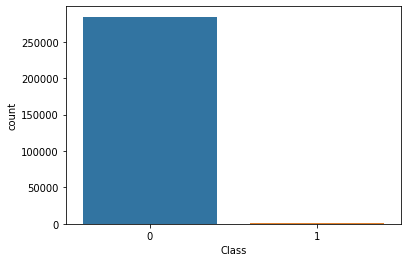

In [0]:
sns.countplot(credit_df['Class'])
plt.show()

**Highly imbalanced data as only 0.172% of transactions are classified as fraud**

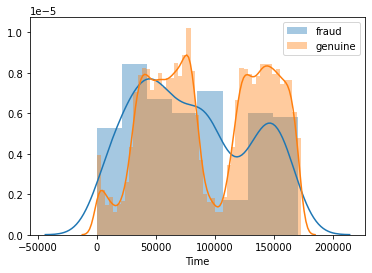

In [0]:
#Check distribution of column 'Time' with respect to fraud and genuine transactions if any pattern is present in the data
sns.distplot(credit_df[credit_df['Class'] == 1]['Time'], label='fraud')
sns.distplot(credit_df[credit_df['Class'] == 0]['Time'], label='genuine')
plt.legend(loc='upper right')
plt.show()

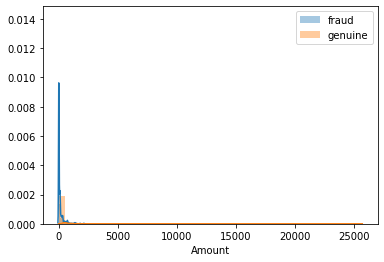

In [0]:
#Check distribution of column 'Amount' with respect to fraud and genuine transactions
sns.distplot(credit_df[credit_df['Class'] == 1]['Amount'], label='fraud')
sns.distplot(credit_df[credit_df['Class'] == 0]['Amount'], label='genuine')
plt.legend(loc='upper right')
plt.show()

In [0]:
#percentile distribution of 'Amount' for fraud transactions
credit_df[credit_df['Class'] == 1]['Amount'].describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
1%          0.000000
5%          0.000000
10%         0.760000
25%         1.000000
50%         9.250000
75%       105.890000
90%       346.746000
95%       640.905000
99%      1357.427900
max      2125.870000
Name: Amount, dtype: float64

In [0]:
#Percentile distribution of 'Amount' for genuine transactions
credit_df[credit_df['Class'] == 0]['Amount'].describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
1%            0.120000
5%            0.920000
10%           1.000000
25%           5.650000
50%          22.000000
75%          77.050000
90%         202.724000
95%         364.409000
99%        1016.966400
max       25691.160000
Name: Amount, dtype: float64

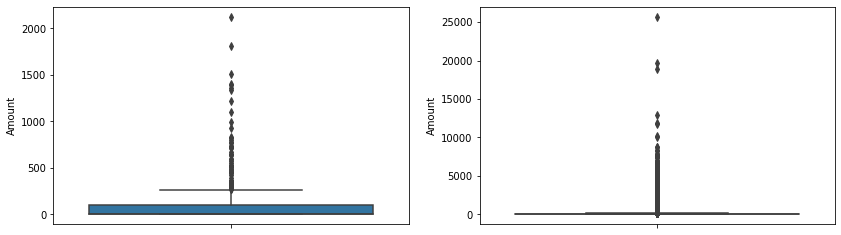

In [0]:
#box plots of feature - 'Amount' for fraud and genuine transactions
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
sns.boxplot(y=credit_df[credit_df['Class'] == 1]['Amount'])

plt.subplot(1,2,2)
sns.boxplot(y=credit_df[credit_df['Class'] == 0]['Amount'])

plt.show()

**Drop columns Time as there doesn't seem to be an indication of fraud/genuine transaction**

In [0]:
credit_df.drop(columns=['Time'], inplace=True)

## Step 3 - Train-Test Split 

In [0]:
y = credit_df.pop('Class')
X = credit_df

In [0]:
#stratify on column 'Class' to ensure majority and minority gets equally distributed in train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 100, stratify=y)

In [10]:
#check distribution of 'Class' in train and test split is maintained as in original data
print ("Train data genuine transactions =>", y_train[y_train.values == 0].count()*100/len(y_train))
print ("Train data fraud transactions =>", y_train.sum()*100/len(y_train))

print ("Test data genuine transactions =>", y_test[y_test.values == 0].count()*100/len(y_test))
print ("Test data fraud transactions =>", y_test.sum()*100/len(y_test))

Train data genuine transactions => 99.82745129511848
Train data fraud transactions => 0.17254870488152324
Test data genuine transactions => 99.8267851082008
Test data fraud transactions => 0.17321489179921118


## Step 4 - Data Transformation

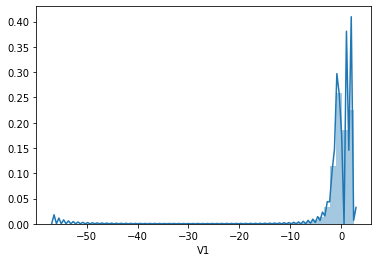

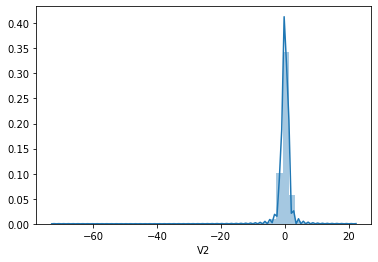

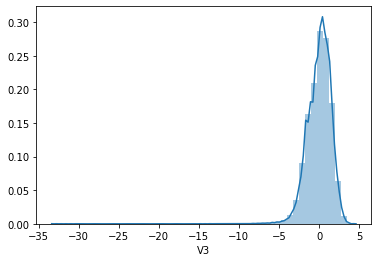

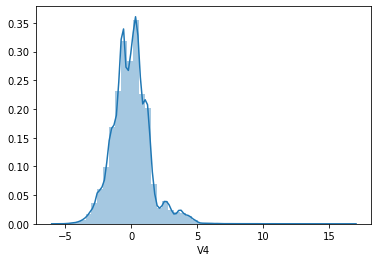

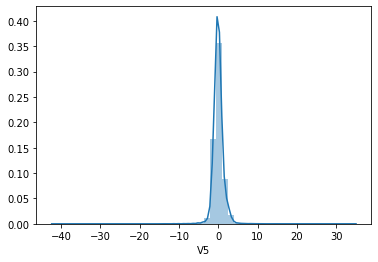

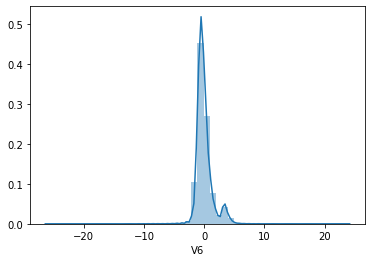

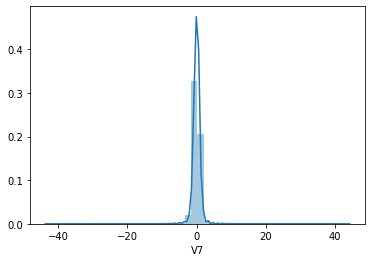

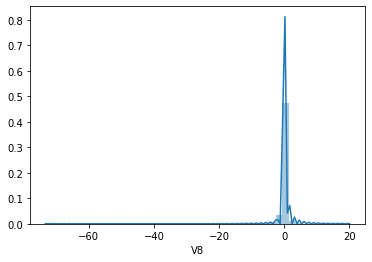

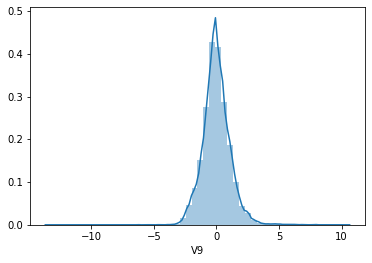

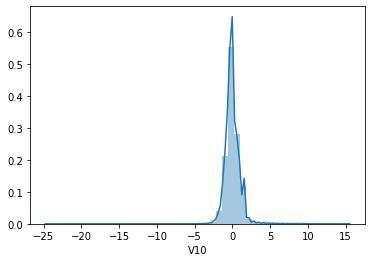

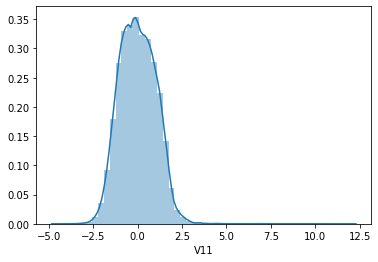

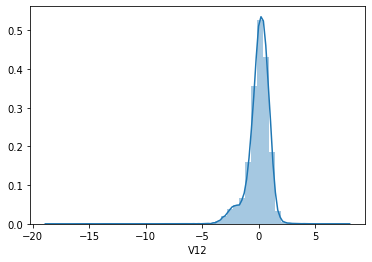

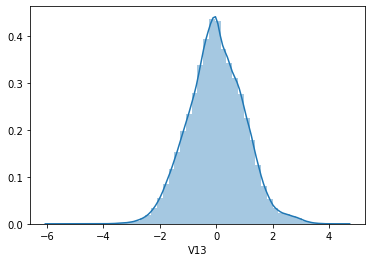

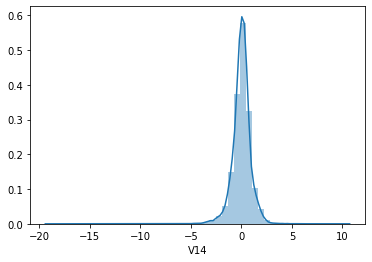

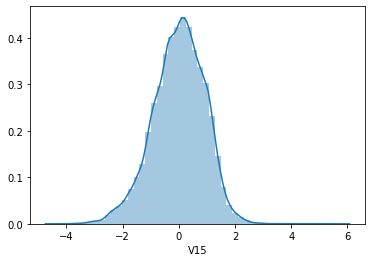

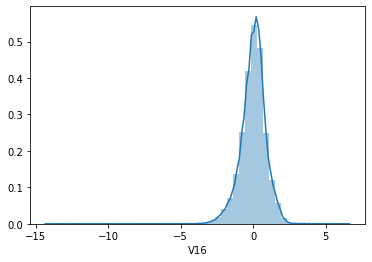

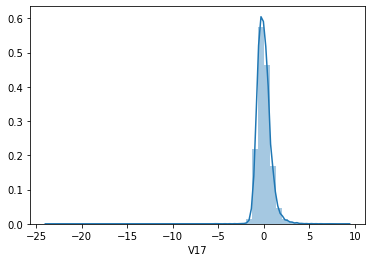

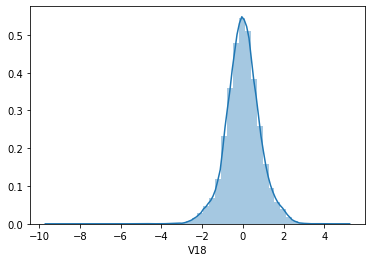

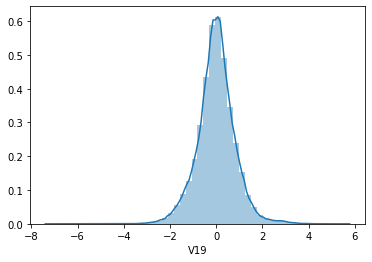

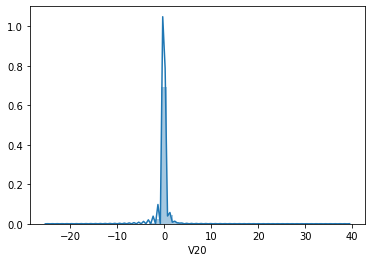

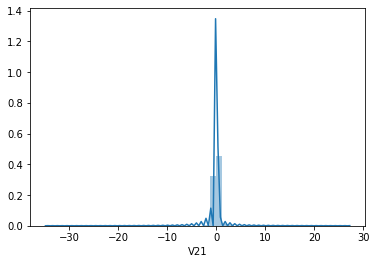

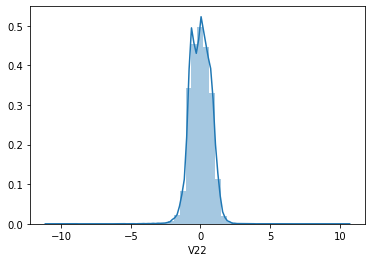

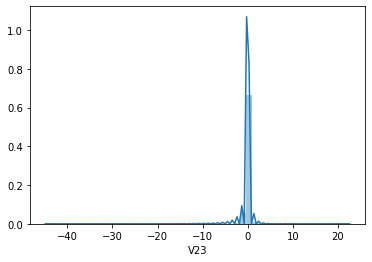

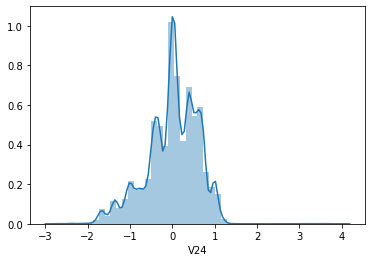

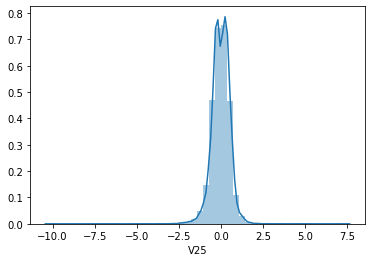

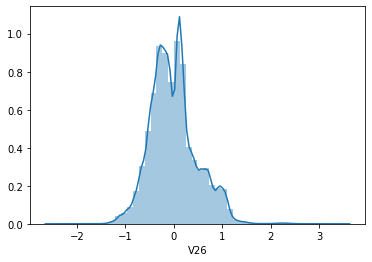

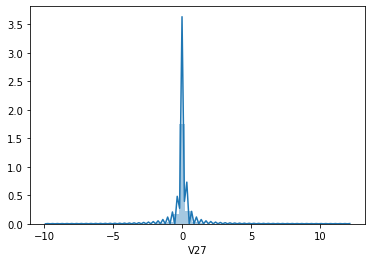

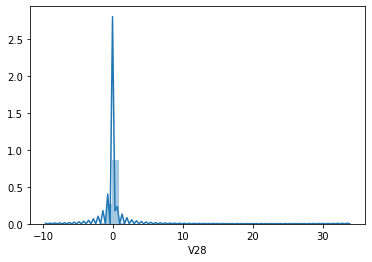

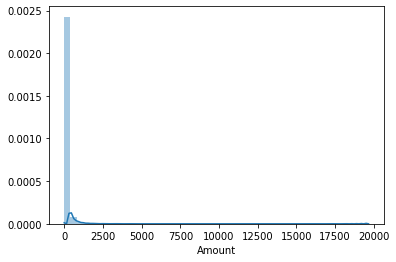

In [11]:
#check distribution of training columns
for col in X_train.columns.tolist():
  sns.distplot(X_train[col])
  plt.show()


In [12]:
#check skewness for every column
for col in X_train.columns.tolist():
  print ("Feature: {0} skew: {1}".format(col, X_train[col].skew()))

Feature: V1 skew: -3.352780393800281
Feature: V2 skew: -4.743314414717319
Feature: V3 skew: -2.115044296160982
Feature: V4 skew: 0.6712343588749465
Feature: V5 skew: -0.3354226905908675
Feature: V6 skew: 1.2132128489589589
Feature: V7 skew: -1.0544407636894357
Feature: V8 skew: -9.04826589585346
Feature: V9 skew: 0.5248531881038306
Feature: V10 skew: 1.0461839272889941
Feature: V11 skew: 0.3372347990100604
Feature: V12 skew: -2.187217141546217
Feature: V13 skew: 0.06792984061116872
Feature: V14 skew: -1.913552066835225
Feature: V15 skew: -0.3112234161397688
Feature: V16 skew: -1.0575028701915397
Feature: V17 skew: -3.526078884894078
Feature: V18 skew: -0.2483541694915622
Feature: V19 skew: 0.11672034533445494
Feature: V20 skew: -1.3777512522033144
Feature: V21 skew: 3.490871900572473
Feature: V22 skew: -0.21868951634168513
Feature: V23 skew: -6.872356257344557
Feature: V24 skew: -0.5406952694368877
Feature: V25 skew: -0.42910082828675233
Feature: V26 skew: 0.5673424705167717
Feature: V

**It is evident from the distribution plots and skewness values, that features are highly skewed, so using PowerTransformer with yeo-johnson transformation to fix the skewness**

In [0]:
#fit and transform on train data
pow_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
train_transformed_vals = pow_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(train_transformed_vals, columns=X_train.columns)

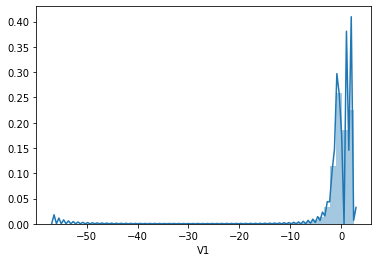

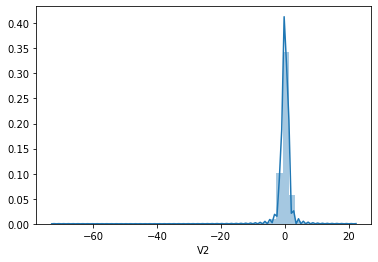

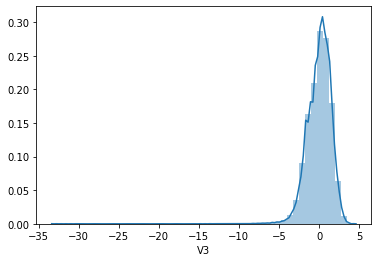

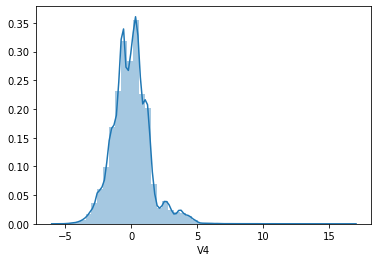

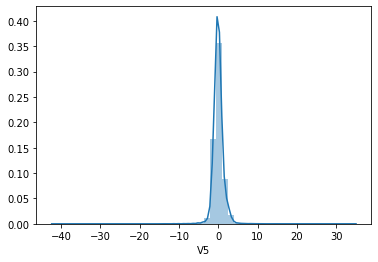

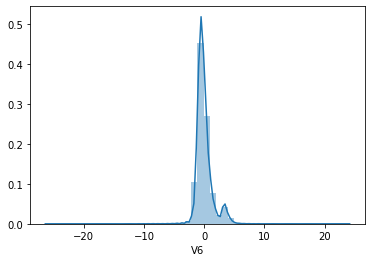

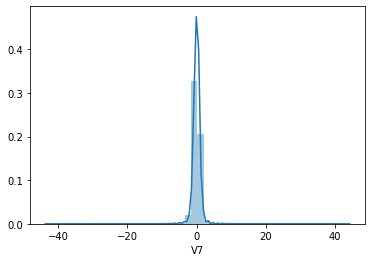

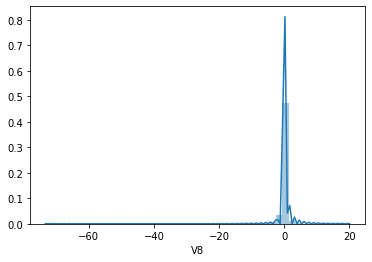

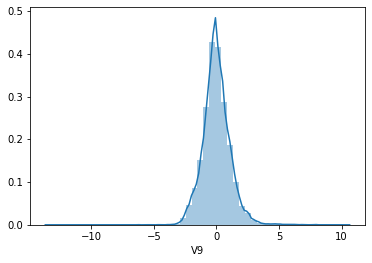

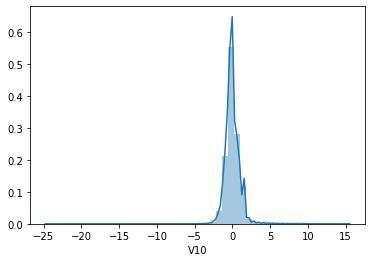

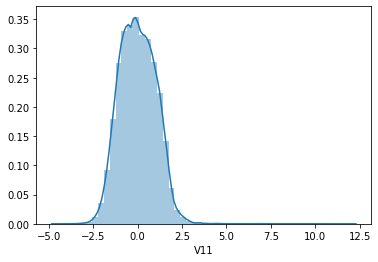

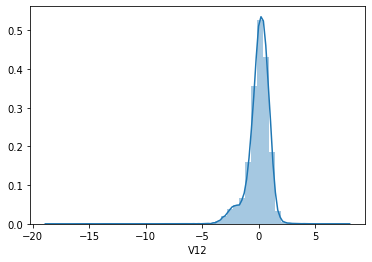

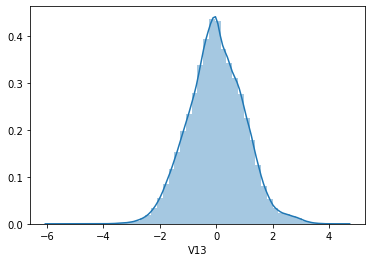

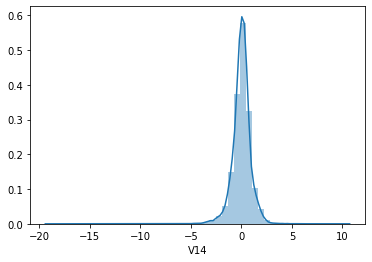

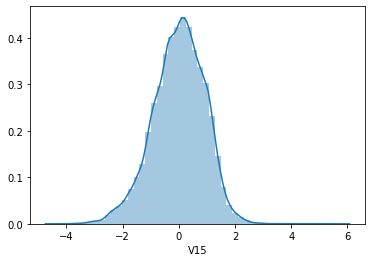

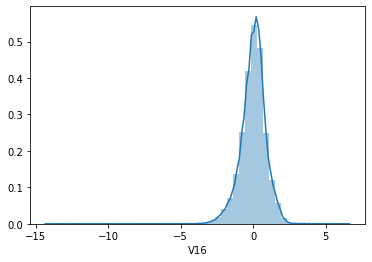

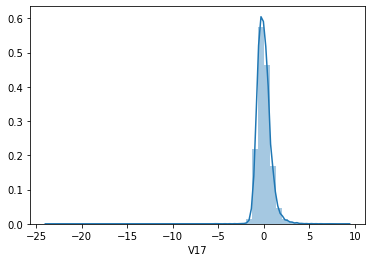

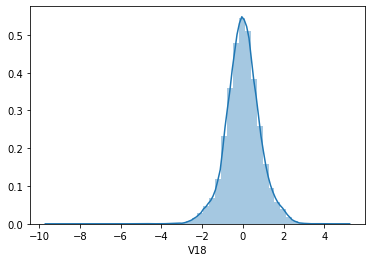

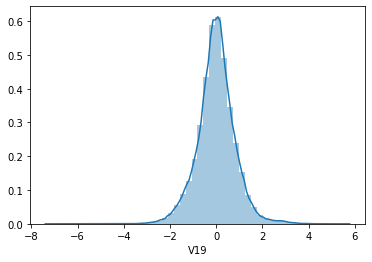

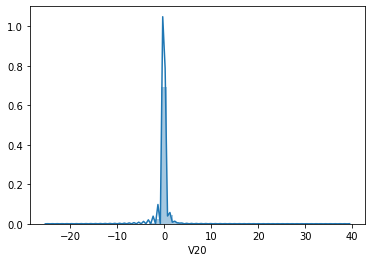

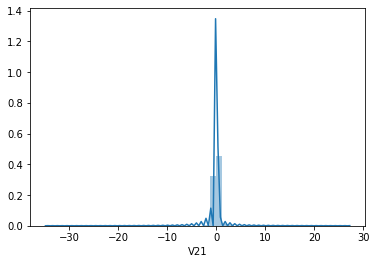

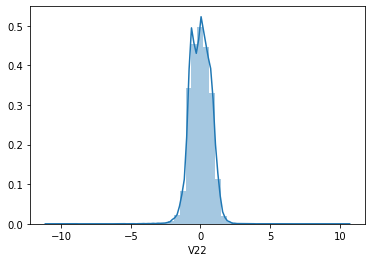

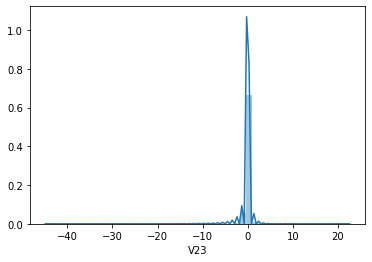

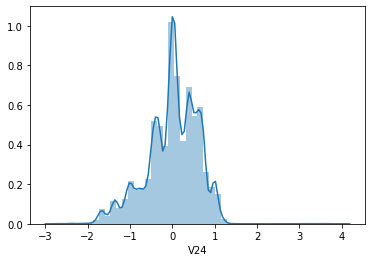

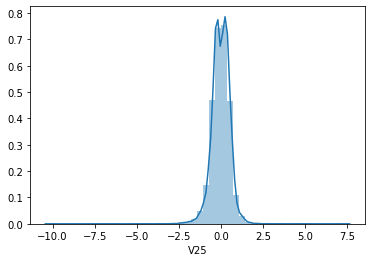

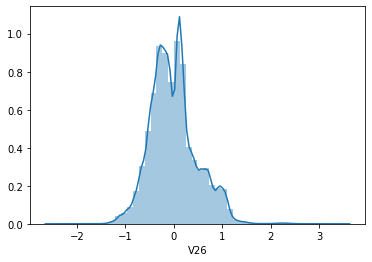

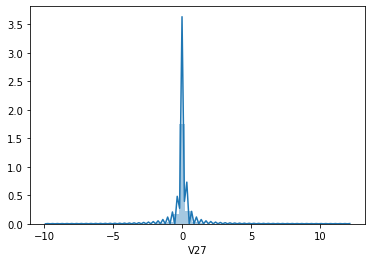

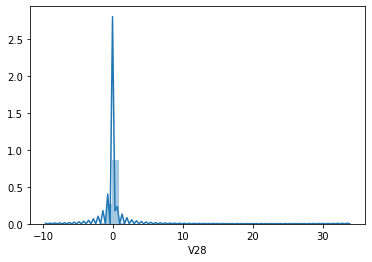

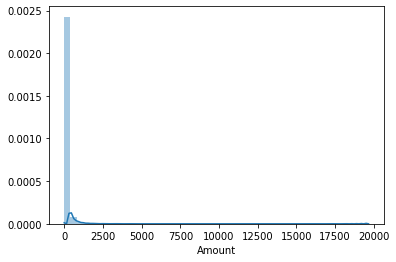

In [14]:
#check distribution of training columns again to ensure skewness is treated
for col in X_train_transformed.columns.tolist():
  sns.distplot(X_train[col])
  plt.show()

In [15]:
#checking the skewness values again
for col in X_train_transformed.columns.tolist():
  print ("Feature: {0} skew: {1}".format(col, X_train_transformed[col].skew()))

Feature: V1 skew: -0.21865876946826787
Feature: V2 skew: 0.34819959396008815
Feature: V3 skew: -0.07935065770840456
Feature: V4 skew: 0.01835838336599849
Feature: V5 skew: -0.3468997814084011
Feature: V6 skew: -1.9937517844552592
Feature: V7 skew: 0.6060208408305281
Feature: V8 skew: 2.3890157742423743
Feature: V9 skew: -0.060697550353436436
Feature: V10 skew: -1.3567704333865427
Feature: V11 skew: 0.05708770496608148
Feature: V12 skew: 0.1653180421030734
Feature: V13 skew: 0.005926257198471918
Feature: V14 skew: 0.10800299935631066
Feature: V15 skew: 0.009912206107950959
Feature: V16 skew: 0.027145020549947323
Feature: V17 skew: -0.8258307453177003
Feature: V18 skew: -0.057165956565338974
Feature: V19 skew: 0.016301667635898638
Feature: V20 skew: -0.4815869170584072
Feature: V21 skew: -2.0813823284034974
Feature: V22 skew: -0.019892712601901646
Feature: V23 skew: -0.02090032753650503
Feature: V24 skew: 0.12327541509731475
Feature: V25 skew: 0.08271823328315821
Feature: V26 skew: -0.02

**skew values indicates that features are either approximately symmetric or moderately skewed**

In [0]:
#using the same transformer on test data
test_transformed_vals = pow_transformer.transform(X_test)
X_test_transformed = pd.DataFrame(test_transformed_vals, columns=X_test.columns)

## Helper functions for model building

In [0]:
#custom function get various metrics for logistic regression model
def get_logistic_metrics(df):
    metrics_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = confusion_matrix(df['actual_default'], df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
    
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        metrics_df.loc[i] =[ i ,accuracy,sensi,speci]
    
    return metrics_df

In [0]:
#custom function to determine output in logistic regression using various cut-off probabilities
def get_prediction_for_cut_off(df):
    cut_off = [float(x)/10 for x in range(10)]
    for c in cut_off:
        df[c] = df['predicted_default_probabilities'].map(lambda x : 1 if x > c else 0)
    return df

In [0]:
#function to draw roc curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

**Keeping n_splits=5 as #1's are too small. With this, there will be around 70 1's in each validation split<br>**
**Evaluation metric - Choosing roc_auc as the scoring we want TPR to be high and at the same time FPR should be low**

In [0]:
#function to perform grid search CV
def gridsearch_cv(X_train, y_train, model, hyper_params):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 100)
    grid_cv = GridSearchCV(estimator = model,
                      param_grid = hyper_params,
                      cv = folds,
                       verbose = True,
                       return_train_score = True,
                       scoring='roc_auc',
                       n_jobs=-1
                      )

    grid_cv.fit(X_train, y_train)
    print ("Best score: ", grid_cv.best_score_)
    print ("Best params: ", grid_cv.best_params_) 

In [0]:
#function to print important features
def print_important_features(model, X_train, y_train):
  var_imp = []
  for i in model.feature_importances_:
      var_imp.append(i)
  print('Top var =', var_imp.index(np.sort(model.feature_importances_)[-1])+1)
  print('2nd Top var =', var_imp.index(np.sort(model.feature_importances_)[-2])+1)
  print('3rd Top var =', var_imp.index(np.sort(model.feature_importances_)[-3])+1)

  # Variable on Index-13 and Index-9 seems to be the top 2 variables
  top_var_index = var_imp.index(np.sort(model.feature_importances_)[-1])
  second_top_var_index = var_imp.index(np.sort(model.feature_importances_)[-2])

  X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
  X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

  np.random.shuffle(X_train_0)

  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['figure.figsize'] = [20, 20]

  plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
  plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
  plt.legend()

In [0]:
#function to print class distribution after over-sampling
def print_class_distribution(X_train, y_train, X_train_over, y_train_over):
  X_train_over_1 = X_train_over[X_train.shape[0]:]

  X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
  X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

  plt.rcParams['figure.figsize'] = [20, 20]
  fig = plt.figure()

  plt.subplot(3, 1, 1)
  plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
  plt.legend()

  plt.subplot(3, 1, 2)
  plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
  plt.scatter(X_train_over_1[:X_train_1.shape[0], 0], X_train_over_1[:X_train_1.shape[0], 1],
            label='Artificial Class-1 Examples')
  plt.legend()

  plt.subplot(3, 1, 3)
  plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
  plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
  plt.legend()

## Step 5 - Model building on imbalanced data sets

**Model 1 - LogisticRegression - As original features were not available, so applying logistic regression first incase data is linearly seperable**

In [0]:
#perform grid serach cv to determine best parameter for regularization
model = LogisticRegression(random_state=100)
hyper_params = {'C':[0.1,0.5,1,2,3,4,5,10,11,12], 'penalty':['l1','l2']}

gridsearch_cv(X_train_transformed,y_train,model,hyper_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.6s finished


Best score:  0.9791444413945468
Best params:  {'C': 0.1, 'penalty': 'l2'}


In [0]:
#Building the final model with tuned parameters
log_reg_5 = LogisticRegression(random_state=100, C=0.1,penalty='l2')
log_reg_5 = log_reg_5.fit(X_train_transformed,y_train)
y_train_pred_prob_5 = log_reg_5.predict_proba(X_train_transformed)

In [0]:
#A seperate dataframe to maintain training predicted probability and predictions with different cut-off
y_train_pred_df_5 = pd.DataFrame({'actual_default':y_train, 'predicted_default_probabilities':y_train_pred_prob_5[:,1]})
y_train_pred_df_5 = get_prediction_for_cut_off(y_train_pred_df_5)

In [0]:
#determine metrics with different cut-off to determine optimal
 y_train_pred_metrics_5 = get_logistic_metrics(y_train_pred_df_5)
 y_train_pred_metrics_5

,prob,accuracy,sensi,speci
0.0,0.0,0.001725,1.000000,0.000000
0.1,0.1,0.999323,0.819767,0.999633
0.2,0.2,0.999343,0.773256,0.999734
0.3,0.3,0.999368,0.738372,0.999819
0.4,0.4,0.999333,0.700581,0.999849
0.5,0.5,0.999283,0.668605,0.999854
0.6,0.6,0.999278,0.651163,0.999879
0.7,0.7,0.999228,0.613372,0.999894
0.8,0.8,0.999177,0.584302,0.999894
0.9,0.9,0.999077,0.526163,0.999894


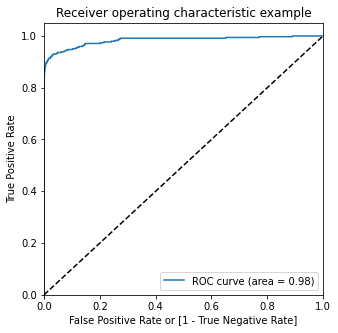

In [0]:
draw_roc(y_train_pred_df_5['actual_default'], y_train_pred_df_5['predicted_default_probabilities'])

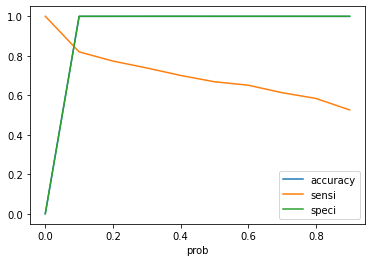

In [0]:
y_train_pred_metrics_5.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Choosing a cut-off of 0.1 to achieve a sensitivity of 0.81**

In [0]:
y_train_pred_df_5['predicted_default'] = y_train_pred_df_5['predicted_default_probabilities'].map(lambda x : 1 if x > 0.1 else 0)

**Predictions on test data**

In [0]:
y_test_pred_prob_5 = log_reg_5.predict_proba(X_test_transformed)

y_test_pred_df_5 = pd.DataFrame({'actual_default':y_test, 'predicted_default_probabilities':y_test_pred_prob_5[:,1]})
y_test_pred_df_5['predicted_default'] = y_test_pred_df_5['predicted_default_probabilities'].map(lambda x : 1 if x > 0.1 else 0)

print ("roc_auc_score: ", roc_auc_score(y_test_pred_df_5['actual_default'], y_test_pred_df_5['predicted_default']))
print ("sensitivity: ", recall_score(y_test_pred_df_5['actual_default'], y_test_pred_df_5['predicted_default']))

roc_auc_score:  0.8916515495506059
sensitivity:  0.7837837837837838


**Model 2 - Decision Tree Classifier**

In [0]:
#perform grid search to tune hyper-parameters
model = DecisionTreeClassifier(random_state=100, max_features='sqrt')
hyper_params = {'max_depth':range(3, 15, 2),'min_samples_leaf': range(50, 200, 50),
                'min_samples_split': range(100, 500, 100),'criterion': ["entropy", "gini"]}

gridsearch_cv(X_train_transformed,y_train,model,hyper_params)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 10.0min finished


Best score:  0.9602864827295694
Best params:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [0]:
#Building the final model with tuned parameters
dtree_5 = DecisionTreeClassifier(random_state=100, max_features='sqrt', max_depth=5, min_samples_leaf=100, min_samples_split=100,
                                 criterion='entropy')

dtree_5.fit(X_train_transformed, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

**Predictions on test data**

In [0]:
y_test_pred = dtree_5.predict(X_test_transformed)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.8578501797418498
sensitivity:  0.7162162162162162


**Model 3 - RandomForestClassifier**

In [0]:
#Invoke gridsearch cv to tune important parameters like n_estimators and max_depth of tree keeping some values constant for other tree parameters
model = RandomForestClassifier(random_state=100, min_samples_split=500, min_samples_leaf=100, max_features='sqrt')
hyper_params = {'n_estimators':range(50,200,50), 'max_depth':range(3,15,2)} 

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 64.9min finished


Best score:  0.979191822967494
Best params:  {'max_depth': 11, 'n_estimators': 150}


In [0]:
#Tuning again for higher number of estimators
model = RandomForestClassifier(random_state=100, min_samples_split=500, min_samples_leaf=100, max_features='sqrt')
hyper_params = {'n_estimators':range(150,300,50), 'max_depth':range(3,15,2)} 

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 128.3min finished


Best score:  0.979191822967494
Best params:  {'max_depth': 11, 'n_estimators': 150}


In [0]:
#Tune other parameters of tree
model = RandomForestClassifier(random_state=100, n_estimators=150, max_depth=11, max_features='sqrt')
hyper_params = {'min_samples_split':range(500,1501,500), 'min_samples_leaf':range(100,201,50)}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 64.8min finished


Best score:  0.9815231066582607
Best params:  {'min_samples_leaf': 150, 'min_samples_split': 500}


In [0]:
#Building a final model with tuned parameters
rforest_5 = RandomForestClassifier(random_state=100, n_estimators=150, max_depth=11, max_features='sqrt', min_samples_split=500, min_samples_leaf=150)
rforest_5 = rforest_5.fit(X_train_transformed, y_train)

**Predictions on test data**

In [0]:
y_test_pred = rforest_5.predict(X_test_transformed)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.7634138593720047
sensitivity:  0.527027027027027


**Model 4 - XGBoost Classifier**

**Fix learning rate 0.1 and tune number of trees by fixing some tree parameters**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
hyper_params = {'n_estimators':range(50,201,50)}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.9min finished


Best score:  0.9833630184322619
Best params:  {'n_estimators': 200}


In [0]:
#trying higher number of estimators
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
hyper_params = {'n_estimators':range(250,401,50)}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 41.1min finished


Best score:  0.9839636351541137
Best params:  {'n_estimators': 400}


In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
hyper_params = {'n_estimators':range(450,550,50)}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 26.5min finished


Best score:  0.9840058957262283
Best params:  {'n_estimators': 500}


In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
hyper_params = {'n_estimators':range(500,601,50)}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 36.9min finished


Best score:  0.9840058957262283
Best params:  {'n_estimators': 500}


**Tune max_depth and min_child_weight**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=500, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
hyper_params = {'max_depth':range(3,15,2), 'min_child_weight':range(1,6,2)}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 174.4min finished


Best score:  0.9828333482401362
Best params:  {'max_depth': 9, 'min_child_weight': 1}


**As few steps above, max_depth=8 had a better score than max_depth=9, so keeping a max_depth of 8**

**Tune gamma**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=500, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1)
hyper_params = {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 76.7min finished


Best score:  0.9842729502439191
Best params:  {'gamma': 0.1}


**Tune sub_sample and colsample_by_tree**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=500, gamma=0.1,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1)
hyper_params = {'subsample':[0.6,0.7,0.8,0.9], 'colsample_bytree':[0.6,0.7,0.8,0.9]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 91.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 173.5min finished


Best score:  0.9847866780815082
Best params:  {'colsample_bytree': 0.8, 'subsample': 0.9}


**Tune regularization parameter - reg_alpha**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=500, gamma=0.1,subsample=0.9,colsample_bytree=0.8,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1)
hyper_params = {'reg_alpha':[0.1,0,1]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 39.7min finished


Best score:  0.9847866780815082
Best params:  {'reg_alpha': 0}


**reg_lambda**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=500, gamma=0.1,subsample=0.9,colsample_bytree=0.8,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1, reg_alpha=0)
hyper_params = {'reg_lambda':[0.01,0.1,0,1,10]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 63.2min finished


Best score:  0.9847866780815082
Best params:  {'reg_lambda': 1}


In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=500, gamma=0.1,subsample=0.9,colsample_bytree=0.8,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1, reg_alpha=0, reg_lambda=1)

model = model.fit(X_train_transformed, y_train)

y_test_pred = model.predict(X_test_transformed)
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.8985958905737322
sensitivity:  0.7972972972972973


**Tune learning rate by trying 0.05 and increasing n_estimators to 1000 proportionally**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.05, n_estimators=1000, gamma=0.1,subsample=0.9,colsample_bytree=0.8,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1, reg_alpha=0, reg_lambda=1)

model = model.fit(X_train_transformed, y_train)

y_test_pred = model.predict(X_test_transformed)
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.8985958905737322
sensitivity:  0.7972972972972973


**Making the final mode with learning rate 0.01 and n_estimators = 5000**

In [0]:
xgb_5 = XGBClassifier(random_state=100, learning_rate=0.01, n_estimators=5000, gamma=0.1,subsample=0.9,colsample_bytree=0.8,
                      scale_pos_weight=1, max_depth=8, min_child_weight=1, reg_alpha=0, reg_lambda=1)

xgb_5 = xgb_5.fit(X_train_transformed, y_train)

y_test_pred = xgb_5.predict(X_test_transformed)
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9019684069437864
sensitivity:  0.8040540540540541


**Model 5 - Support Vector Classifier**

**Tune hyper-parameters using 'linear' kernel function**

In [0]:
model = SVC(random_state=100, kernel='linear')
hyper_params={'C':[0.001,0.01,0.1,1]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.8min finished


Best score:  0.9758527515859254
Best params:  {'C': 0.01}


**Building a model with kernal - 'linear' and C 0.01**

In [0]:
svm_5 = SVC(random_state=100, kernel='linear',C=0.01)
svm_5 = svm_5.fit(X_train_transformed, y_train)

**Predictions on test data**

In [0]:
y_test_pred = svm_5.predict(X_test_transformed)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.8917101696338463
sensitivity:  0.7837837837837838


**Tune hyper-parameters using polynomial kernel**

In [0]:
model = SVC(random_state=100,kernel='poly')            
hyper_params={'C':[0.001,0.01,0.1,1], 'degree':[2,3,4]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 19.1min finished


Best score:  0.9355587198243258
Best params:  {'C': 0.1, 'degree': 2}


**Building a model with kernal - 'poly' and c - 0.1 and degree - 2**

In [0]:
svm_5 = SVC(random_state=100, kernel='poly',C=0.1,degree=2)
svm_5 = svm_5.fit(X_train_transformed, y_train)

**Predictions on test set**

In [0]:
y_test_pred = svm_5.predict(X_test_transformed)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.8546769716548133
sensitivity:  0.7094594594594594


**Tune hyper-parameter using rbf kernel**

In [0]:
model = SVC(random_state=100,kernel='rbf')            
hyper_params={'C':[0.001,0.01], 'gamma':[0.001,0.01,0.1,1]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 35.1min finished


Best score:  0.9581509027654089
Best params:  {'C': 0.01, 'gamma': 0.01}


In [0]:
model = SVC(random_state=100,kernel='rbf')            
hyper_params={'C':[0.1], 'gamma':[0.001,0.01,0.1,1]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 70.7min finished


Best score:  0.9670394218756305
Best params:  {'C': 0.1, 'gamma': 1}


In [0]:
model = SVC(random_state=100,kernel='rbf')            
hyper_params={'C':[1], 'gamma':[0.001,0.01,0.1,1]}

gridsearch_cv(X_train_transformed, y_train, model, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 179.3min finished


Best score:  0.9728095663208375
Best params:  {'C': 1, 'gamma': 1}


**Building a model with kernel -'rbf' and C - 1 and gamma - 1**

In [0]:
svm_5 = SVC(random_state=100,kernel='rbf',C=1,gamma=1)
svm_5 = svm_5.fit(X_train_transformed, y_train)       

**Predictions on test data set**

In [0]:
y_test_pred = svm_5.predict(X_test_transformed)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.5337837837837838
sensitivity:  0.06756756756756757


## **Conclusion: Using imbalanced data, below is the test roc auc score for different models in decreasing order of the score:**
**XGboost Classifier: 0.9019<br>
Logistic Regression: 0.8916<br>
SVM with linear kernel: 0.8917<br>
Decision Tree Classifier: 0.8578<br>
SVM with polynomial kernel of degree 2: 0.8546<br>
RandomForestClassifier: 0.7634<br>
SVM with RBF kernel: 0.5337<br><br>
Linear models like Logistic Regression, SVM sees to do well on data. Along with XGBoost where multiple weak learners together gives a highest performing score on imbalanaced data. These three models will be used further to check performance on data with different balancing techniques**




Top var = 17
2nd Top var = 14
3rd Top var = 12


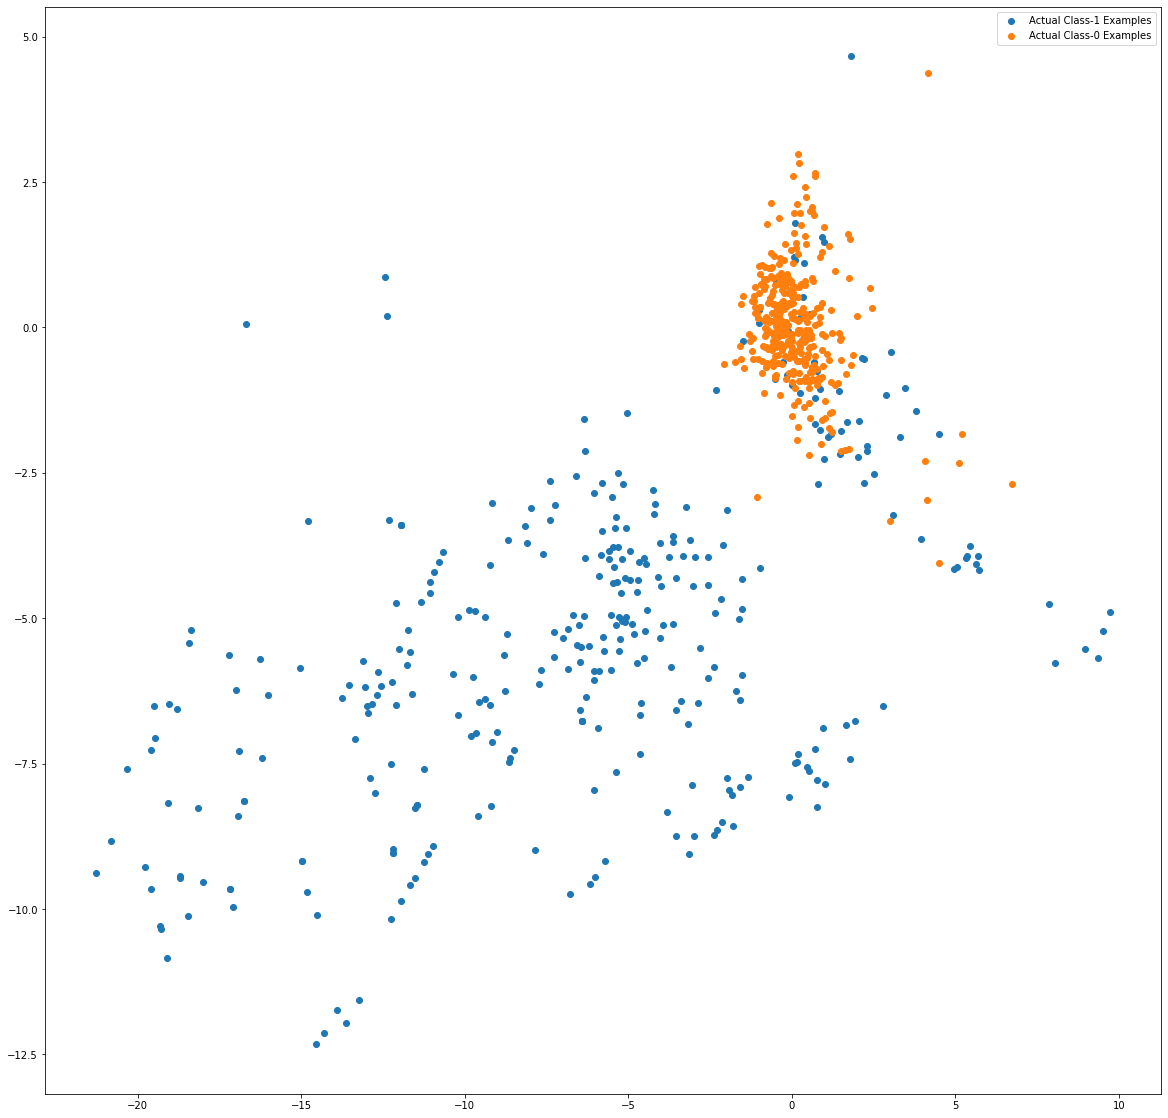

In [0]:
#print important feature using XGBClassifier model(xgb_5) as it is the best performing model on imbalanced data set
print_important_features(xgb_5, X_train_transformed, y_train)

## Step 6 - Model building with Data balancing technique: Random Oversampling

**Model 1 - Logistic Regression**

In [0]:
#perform grid serach cv to determine best parameter for regularization
pipeline_log_reg_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',LogisticRegression(random_state=100))])
hyper_params = {'model__C':[0.1,0.5,1,2,3,4,5,10,11,12], 'model__penalty':['l1','l2']}

gridsearch_cv(X_train_transformed, y_train, pipeline_log_reg_6, hyper_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.4s finished


Best score:  0.9792133382388709
Best params:  {'model__C': 0.1, 'model__penalty': 'l2'}


In [0]:
#Building the final model with over-sampling and tuned parameters
sampler = RandomOverSampler(random_state=100)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)
y_train_over = pd.Series(y_train_over)

log_reg_6 = LogisticRegression(random_state=100, C=0.1,penalty='l2')
log_reg_6 = log_reg_6.fit(X_train_transformed_over, y_train_over)
y_train_pred_prob_6 = log_reg_6.predict_proba(X_train_transformed_over)

In [0]:
#A seperate dataframe to maintain training predicted probability and predictions with different cut-off
y_train_pred_df_6 = pd.DataFrame({'actual_default':y_train_over, 'predicted_default_probabilities':y_train_pred_prob_6[:,1]})
y_train_pred_df_6 = get_prediction_for_cut_off(y_train_pred_df_6)

In [0]:
#determine metrics with different cut-off to determine optimal
y_train_pred_metrics_6 = get_logistic_metrics(y_train_pred_df_6)
y_train_pred_metrics_6

,prob,accuracy,sensi,speci
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.901899,0.979635,0.824163
0.2,0.2,0.936047,0.965159,0.906934
0.3,0.3,0.947083,0.950894,0.943272
0.4,0.4,0.952703,0.942272,0.963134
0.5,0.5,0.954193,0.933464,0.974922
0.6,0.6,0.953728,0.924585,0.982871
0.7,0.7,0.948442,0.907738,0.989147
0.8,0.8,0.943455,0.893398,0.993513
0.9,0.9,0.933781,0.870340,0.997221


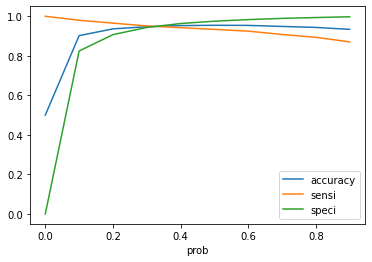

In [0]:
y_train_pred_metrics_6.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Choosing a cut-off of 0.3 as optimal cut-off**

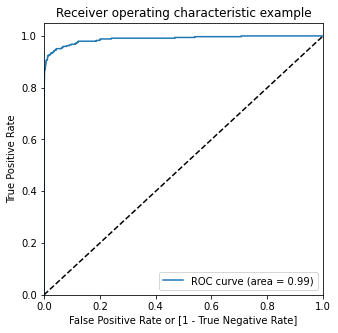

In [0]:
draw_roc(y_train_pred_df_6['actual_default'], y_train_pred_df_6['predicted_default_probabilities'])

**Predictions on test data**

In [0]:
y_test_pred_prob_6 = log_reg_6.predict_proba(X_test_transformed)

y_test_pred_df_6 = pd.DataFrame({'actual_default':y_test, 'predicted_default_probabilities':y_test_pred_prob_6[:,1]})
y_test_pred_df_6['predicted_default'] = y_test_pred_df_6['predicted_default_probabilities'].map(lambda x : 1 if x > 0.3 else 0)

print ("roc_auc_score: ", roc_auc_score(y_test_pred_df_6['actual_default'], y_test_pred_df_6['predicted_default']))
print ("sensitivity: ", recall_score(y_test_pred_df_6['actual_default'], y_test_pred_df_6['predicted_default']))

roc_auc_score:  0.9276679267344019
sensitivity:  0.9121621621621622


**Model 2 - SVM with Linear kernel**

In [0]:
#perform grid serach cv to determine best parameter for penalty
pipeline_svm_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',SVC(random_state=100, kernel='linear'))])
hyper_params = {'model__C':[0.001,0.01]}

gridsearch_cv(X_train_transformed, y_train, pipeline_svm_6, hyper_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 129.4min finished


Best score:  0.9784957566586077
Best params:  {'model__C': 0.001}


In [0]:
#perform grid serach cv to determine best parameter for penalty
pipeline_svm_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',SVC(random_state=100, kernel='linear'))])
hyper_params = {'model__C':[0.0001]}

gridsearch_cv(X_train_transformed, y_train, pipeline_svm_6, hyper_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 93.6min finished


Best score:  0.9786756802706664
Best params:  {'model__C': 0.0001}


**Building a final model with kernel - 'linear' and C - 0.0001**

In [0]:
sampler = RandomOverSampler(random_state=100)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

svm_6 = SVC(random_state=100, kernel='linear',C=0.0001)
svm_6 = svm_6.fit(X_train_transformed_over, y_train_over)

y_test_pred = svm_6.predict(X_test_transformed)
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.924694581444684
sensitivity:  0.8648648648648649


**Model 3 - XGBoost Classifier**

**As xgboost and gridsearch cv runs into issues of feature names mismatch, transforming X_train_transformed and y_train into a matrix**

In [0]:
X_train_transformed_matrix = np.array(X_train_transformed)
y_train_matrix = np.array(y_train)

**Fix learning rate 0.1 and tune number of trees by fixing some tree parameters**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__n_estimators':range(50,201,50)}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 20.5min finished


Best score:  0.9854404591877864
Best params:  {'model__n_estimators': 150}


**Tune max_depth and min_child_weight**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__max_depth':range(3,15,2), 'model__min_child_weight':range(1,6,2)}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 94.8min finished


Best score:  0.9866987100817877
Best params:  {'model__max_depth': 13, 'model__min_child_weight': 1}


In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__max_depth':[13,14,15,16]}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 29.5min finished


Best score:  0.9866987100817877
Best params:  {'model__max_depth': 13}


**Tune gamma**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, max_depth=13, min_child_weight=1,subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__gamma':[0,0.1,0.2,0.3,0.4,0.5]}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.3min finished


Best score:  0.9867618926516573
Best params:  {'model__gamma': 0.1}


**Tune subsample and colsample_by_tree**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, max_depth=13, min_child_weight=1, gamma=0.1,
                      scale_pos_weight=1)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__subsample':[0.6,0.7,0.8,0.9], 'model__colsample_bytree':[0.6,0.7,0.8,0.9]}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 109.7min finished


Best score:  0.9871955424718376
Best params:  {'model__colsample_bytree': 0.8, 'model__subsample': 0.9}


**Tune regularization parameter - reg_alpha**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, max_depth=13, min_child_weight=1, gamma=0.1,
                      subsample=0.9,colsample_bytree=0.8,scale_pos_weight=1)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__reg_alpha':[0.1,0,1]}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 22.6min finished


Best score:  0.9871955424718376
Best params:  {'model__reg_alpha': 0}


**reg_lambda**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, max_depth=13, min_child_weight=1, gamma=0.1,
                      subsample=0.9,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0)
pipeline_xgb_6 = Pipeline([('over',RandomOverSampler(random_state=100)), ('model',model)])
hyper_params = {'model__reg_lambda':[0.01,0.1,0,1,10]}

gridsearch_cv(X_train_transformed_matrix, y_train_matrix, pipeline_xgb_6, hyper_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 40.6min finished


Best score:  0.9871955424718376
Best params:  {'model__reg_lambda': 1}


**Building a model with tuned parameters before tuning learning rate further**

In [0]:
sampler = RandomOverSampler(random_state=100)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, max_depth=13, min_child_weight=1, gamma=0.1,
                      subsample=0.9,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

X_train_transformed_over_matrix = np.array(X_train_transformed_over)
y_train_over_matrix = np.array(y_train_over)

model = model.fit(X_train_transformed_over_matrix, y_train_over_matrix)

X_test_transformed_matrix = np.array(X_test_transformed)
y_test_pred = model.predict(X_test_transformed_matrix)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9154526104156797
sensitivity:  0.831081081081081


**Tune learning rate by trying its half value 0.05 and increasing n_estimators to 300 proportionally from 150**

In [0]:
sampler = RandomOverSampler(random_state=100)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

model = XGBClassifier(random_state=100, learning_rate=0.05, n_estimators=300, max_depth=13, min_child_weight=1, gamma=0.1,
                      subsample=0.9,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

X_train_transformed_over_matrix = np.array(X_train_transformed_over)
y_train_over_matrix = np.array(y_train_over)

model = model.fit(X_train_transformed_over_matrix, y_train_over_matrix)

X_test_transformed_matrix = np.array(X_test_transformed)
y_test_pred = model.predict(X_test_transformed_matrix)

print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9154408863990318
sensitivity:  0.831081081081081


**Not a significant difference on reducing the learning rate, building a final model with learning rate  0.1 and n_estimators 150 and other tuned parameters of tree**

In [0]:
sampler = RandomOverSampler(random_state=100)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

xgb_6 = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=150, max_depth=13, min_child_weight=1, gamma=0.1,
                      subsample=0.9,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

xgb_6 = model.fit(np.array(X_train_transformed_over), np.array(y_train_over))

y_test_pred = xgb_6.predict(np.array(X_test_transformed))
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9154408863990318
sensitivity:  0.831081081081081


## **Conclusion: Using balancing technique - RandomOversampler, below is the test roc auc score for different models in decreasing order of the score:**
**Logistic Regression: 0.9276<br>
SVM with linear kernel: 0.9246<br>
XGboost Classifier: 0.9154<br>**


## Step 7 - Model building with Data balancing technique: SMOTE

**Model 1 - Logistic Regression**

In [0]:
#perform grid serach cv to determine best parameter for regularization
pipeline_log_reg_7 = Pipeline([('over',SMOTE(random_state=100)), ('model',LogisticRegression(random_state=100))])
hyper_params = {'over__k_neighbors':range(3,8,1), 'model__C':[0.1,0.5,1,2,3,4,5,10,11,12], 'model__penalty':['l1','l2']}

gridsearch_cv(X_train_transformed, y_train, pipeline_log_reg_7, hyper_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


Best score:  0.9774707468985069
Best params:  {'model__C': 0.1, 'model__penalty': 'l2', 'over__k_neighbors': 5}


In [0]:
#Building the final model with over-sampling and tuned parameters
sampler = SMOTE(random_state=100, k_neighbors=5)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)
y_train_over = pd.Series(y_train_over)

log_reg_7 = LogisticRegression(random_state=100, C=0.1,penalty='l2')
log_reg_7 = log_reg_7.fit(X_train_transformed_over, y_train_over)
y_train_pred_prob_7 = log_reg_7.predict_proba(X_train_transformed_over)

In [0]:
#A seperate dataframe to maintain training predicted probability and predictions with different cut-off
y_train_pred_df_7 = pd.DataFrame({'actual_default':y_train_over, 'predicted_default_probabilities':y_train_pred_prob_7[:,1]})
y_train_pred_df_7 = get_prediction_for_cut_off(y_train_pred_df_7)

In [0]:
#determine metrics with different cut-off to determine optimal
y_train_pred_metrics_7 = get_logistic_metrics(y_train_pred_df_7)
y_train_pred_metrics_7

,prob,accuracy,sensi,speci
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.904000,0.988318,0.819681
0.2,0.2,0.938232,0.970777,0.905688
0.3,0.3,0.946503,0.950638,0.942368
0.4,0.4,0.948734,0.936328,0.961140
0.5,0.5,0.949083,0.926048,0.972118
0.6,0.6,0.948900,0.917295,0.980504
0.7,0.7,0.946340,0.906517,0.986162
0.8,0.8,0.942393,0.893312,0.991473
0.9,0.9,0.932168,0.868872,0.995463


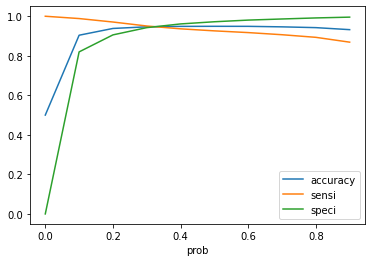

In [0]:
y_train_pred_metrics_7.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Choosing 0.3 as optimal cut-off**

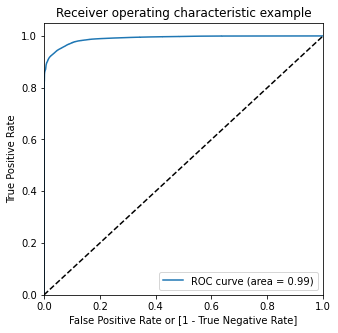

In [0]:
draw_roc(y_train_pred_df_7['actual_default'], y_train_pred_df_7['predicted_default_probabilities'])

**Predictions on test data**

In [0]:
y_test_pred_prob_7 = log_reg_7.predict_proba(X_test_transformed)

y_test_pred_df_7 = pd.DataFrame({'actual_default':y_test, 'predicted_default_probabilities':y_test_pred_prob_7[:,1]})
y_test_pred_df_7['predicted_default'] = y_test_pred_df_7['predicted_default_probabilities'].map(lambda x : 1 if x > 0.3 else 0)

print ("roc_auc_score: ", roc_auc_score(y_test_pred_df_7['actual_default'], y_test_pred_df_7['predicted_default']))
print ("sensitivity: ", recall_score(y_test_pred_df_7['actual_default'], y_test_pred_df_7['predicted_default']))

roc_auc_score:  0.9274275843931158
sensitivity:  0.9121621621621622


**Model 2 - SVM with linear kernel**

In [0]:
#perform grid serach cv to determine best parameter for penalty
pipeline_svm_7 = Pipeline([('over',SMOTE(random_state=100)), ('model',SVC(random_state=100, kernel='linear'))])
hyper_params = {'over__k_neighbors':range(4,8,1), 'model__C':[0.001]}

gridsearch_cv(X_train_transformed, y_train, pipeline_svm_7, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 199.3min finished


Best score:  0.978444704071262
Best params:  {'model__C': 0.001, 'over__k_neighbors': 5}


In [0]:
#perform grid serach cv to determine best parameter for penalty
pipeline_svm_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',SVC(random_state=100, kernel='linear'))])
hyper_params = {'model__C':[0.0001, 0.01]}

gridsearch_cv(X_train_transformed, y_train, pipeline_svm_7, hyper_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 289.8min finished


Best score:  0.9782727157616226
Best params:  {'model__C': 0.0001}


**Building a final model with kernel - 'linear' and C - 0.001**

In [25]:
sampler = SMOTE(random_state=100, k_neighbors=5)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

svm_7 = SVC(random_state=100, kernel='linear',C=0.001)
svm_7 = svm_7.fit(X_train_transformed_over, y_train_over)

y_test_pred = svm_7.predict(X_test_transformed)
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9344857196724246
sensitivity:  0.8918918918918919


**print class distribution after over-sampling**

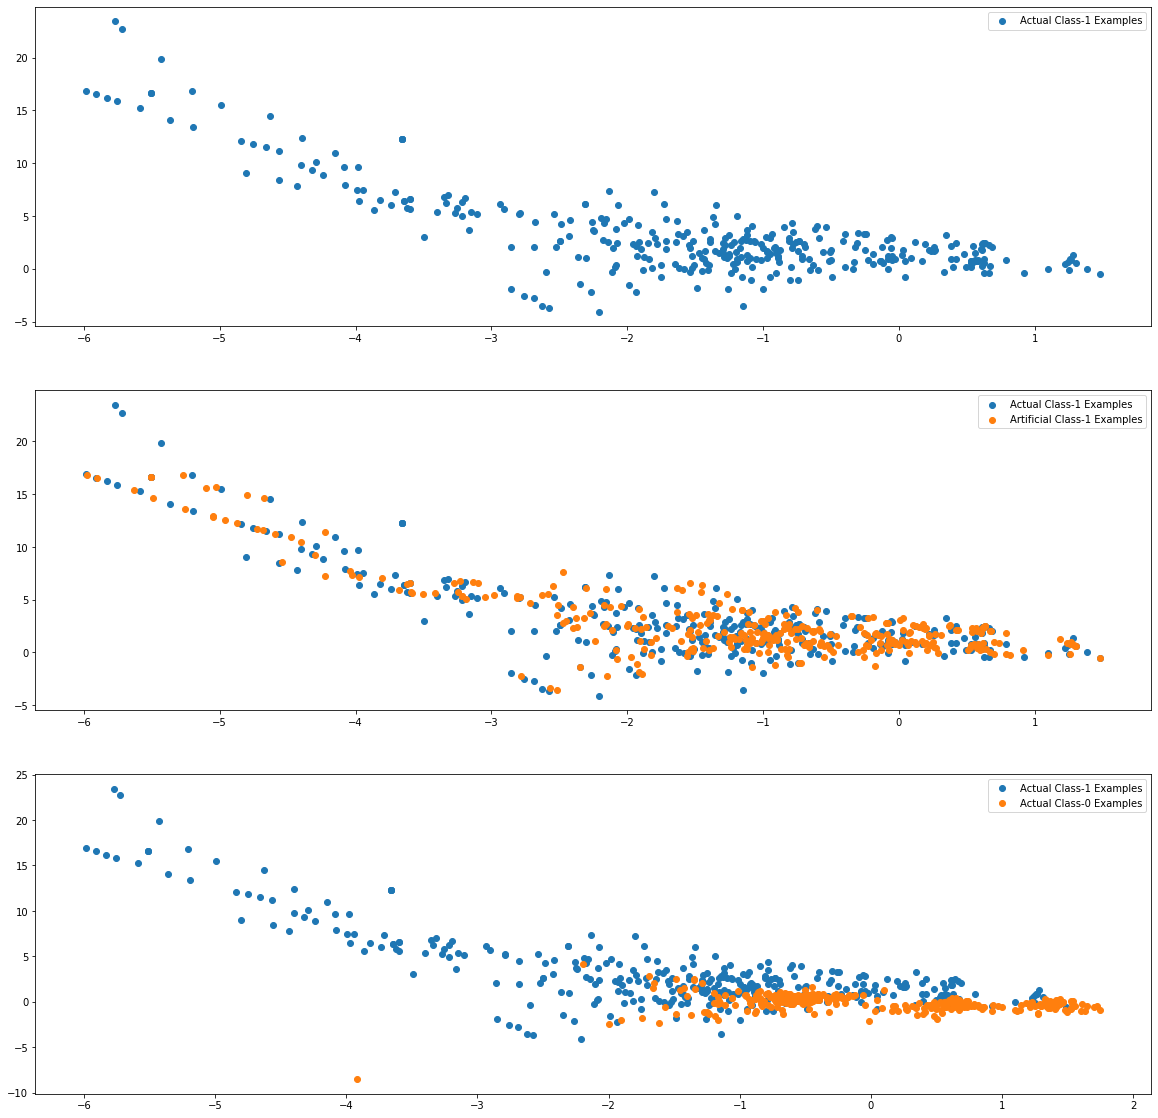

In [26]:
print_class_distribution(X_train_transformed, y_train, X_train_transformed_over, y_train_over)

**Model 3 - XGBoost Classifier**

**Fix learning rate 0.1 and tune number of trees by fixing some tree parameters**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100)), ('model',model)])
hyper_params = {'over__k_neighbors':range(3,8,1), 'model__n_estimators':range(50,201,50)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 39.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 147.3min finished


Best score:  0.9851760540544664
Best params:  {'model__n_estimators': 200, 'over__k_neighbors': 5}


**Trying higher number of estimators**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__n_estimators':range(250,401,50)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 65.3min finished


Best score:  0.9851391950566301
Best params:  {'model__n_estimators': 350}


**Tune max_depth and min_child_weight with n_estimators=200**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__max_depth':range(3,15,2), 'model__min_child_weight':range(1,6,2)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 59.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 171.1min finished


Best score:  0.9868960785084766
Best params:  {'model__max_depth': 9, 'model__min_child_weight': 1}


**Tune gamma**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=9, min_child_weight=1,subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__gamma':[0,0.1,0.2,0.3,0.4,0.5]}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 71.2min finished


Best score:  0.9873286038930915
Best params:  {'model__gamma': 0.4}


**Tune subsample and colsample_by_tree**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=9, min_child_weight=1, gamma=0.4,
                      scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__subsample':[0.6,0.7], 'model__colsample_bytree':[0.6,0.7,0.8,0.9]}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 79.2min finished


Best score:  0.9860463586150141
Best params:  {'model__colsample_bytree': 0.7, 'model__subsample': 0.7}


In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=9, min_child_weight=1, gamma=0.4,
                      scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__subsample':[0.8,0.9], 'model__colsample_bytree':[0.6,0.7,0.8,0.9]}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 95.0min finished


Best score:  0.9873286038930915
Best params:  {'model__colsample_bytree': 0.8, 'model__subsample': 0.8}


**Tune regularization parameter - reg_alpha**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=9, min_child_weight=1, gamma=0.4,
                      subsample=0.8,colsample_bytree=0.8,scale_pos_weight=1)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__reg_alpha':[0.1,0,1]}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 36.1min finished


Best score:  0.9873286038930915
Best params:  {'model__reg_alpha': 0}


**reg_lambda**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=9, min_child_weight=1, gamma=0.4,
                      subsample=0.8,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0)
pipeline_xgb_7 = Pipeline([('over',SMOTE(random_state=100, k_neighbors=5)), ('model',model)])
hyper_params = {'model__reg_lambda':[0.01,0.1,0,1,10]}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_7, hyper_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 64.5min finished


Best score:  0.9873286038930915
Best params:  {'model__reg_lambda': 1}


**Building a model with tuned parameters before tuning learning rate further**

In [0]:
sampler = SMOTE(random_state=100, k_neighbors=5)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=200, max_depth=9, min_child_weight=1, gamma=0.4,
                      subsample=0.8,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

model = model.fit(np.array(X_train_transformed_over), np.array(y_train_over))

y_test_pred = model.predict(np.array(X_test_transformed))
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9153119222159026
sensitivity:  0.831081081081081


**Tune learning rate by trying its half value 0.05 and increasing n_estimators to 400 proportionally from 200**

In [0]:
sampler = SMOTE(random_state=100, k_neighbors=5)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

model = XGBClassifier(random_state=100, learning_rate=0.05, n_estimators=400, max_depth=9, min_child_weight=1, gamma=0.4,
                      subsample=0.8,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

model = model.fit(np.array(X_train_transformed_over), np.array(y_train_over))

y_test_pred = model.predict(np.array(X_test_transformed))
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9187078866192531
sensitivity:  0.8378378378378378


**Building a final model with learning rate 0.05 and n_estimators 400**

In [0]:
sampler = SMOTE(random_state=100, k_neighbors=5)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

xgb_7 = XGBClassifier(random_state=100, learning_rate=0.05, n_estimators=400, max_depth=9, min_child_weight=1, gamma=0.4,
                      subsample=0.8,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

xgb_7 = xgb_7.fit(np.array(X_train_transformed_over), np.array(y_train_over))

y_test_pred = xgb_7.predict(np.array(X_test_transformed))
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9187078866192531
sensitivity:  0.8378378378378378


## **Conclusion: Using balancing technique - SMOTE, below is the test roc auc score for different models in decreasing order of the score:**
**SVM with linear kernel: 0.9344<br>
Logistic Regression: 0.9274<br>
XGboost Classifier: 0.9187<br>**

## Step 8 - Model building with Data balancing technique: ADASYN

**Model 1 - Logistic Regression**

In [0]:
#perform grid search cv to determine best parameter for regularization
pipeline_log_reg_8 = Pipeline([('over',ADASYN(random_state=100)), ('model',LogisticRegression(random_state=100))])
hyper_params = {'over__n_neighbors':range(3,8,1), 'model__C':[0.1,0.5,1,2,3,4,5,10,11,12], 'model__penalty':['l1','l2']}

gridsearch_cv(X_train_transformed, y_train, pipeline_log_reg_8, hyper_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.4min finished


Best score:  0.9748041865070647
Best params:  {'model__C': 0.1, 'model__penalty': 'l2', 'over__n_neighbors': 6}


In [0]:
#Building the final model with over-sampling and tuned parameters
sampler = ADASYN(random_state=100, n_neighbors=6)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)
y_train_over = pd.Series(y_train_over)

log_reg_8 = LogisticRegression(random_state=100, C=0.1,penalty='l2')
log_reg_8 = log_reg_8.fit(X_train_transformed_over, y_train_over)
y_train_pred_prob_8 = log_reg_8.predict_proba(X_train_transformed_over)

In [0]:
#A seperate dataframe to maintain training predicted probability and predictions with different cut-off
y_train_pred_df_8 = pd.DataFrame({'actual_default':y_train_over, 'predicted_default_probabilities':y_train_pred_prob_8[:,1]})
y_train_pred_df_8 = get_prediction_for_cut_off(y_train_pred_df_8)

In [0]:
#determine metrics with different cut-off to determine optimal
y_train_pred_metrics_8 = get_logistic_metrics(y_train_pred_df_8)
y_train_pred_metrics_8

,prob,accuracy,sensi,speci
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.816368,0.994619,0.638117
0.2,0.2,0.878977,0.975771,0.782183
0.3,0.3,0.900457,0.952040,0.848874
0.4,0.4,0.907695,0.926480,0.888911
0.5,0.5,0.901618,0.887428,0.915807
0.6,0.6,0.892398,0.846774,0.938021
0.7,0.7,0.873985,0.793197,0.954773
0.8,0.8,0.854994,0.741187,0.968802
0.9,0.9,0.831050,0.680489,0.981610


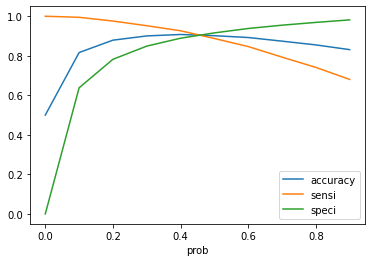

In [0]:
y_train_pred_metrics_8.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Choosing 0.48 as optimal cut-off**

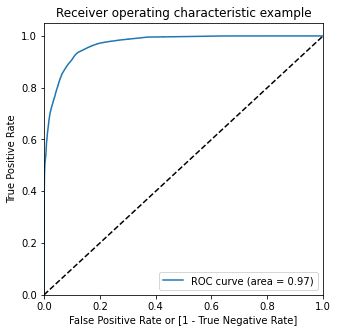

In [0]:
draw_roc(y_train_pred_df_8['actual_default'], y_train_pred_df_8['predicted_default_probabilities'])

**Predictions on test data**

In [0]:
y_test_pred_prob_8 = log_reg_8.predict_proba(X_test_transformed)

y_test_pred_df_8 = pd.DataFrame({'actual_default':y_test, 'predicted_default_probabilities':y_test_pred_prob_8[:,1]})
y_test_pred_df_8['predicted_default'] = y_test_pred_df_8['predicted_default_probabilities'].map(lambda x : 1 if x > 0.48 else 0)

print ("roc_auc_score: ", roc_auc_score(y_test_pred_df_8['actual_default'], y_test_pred_df_8['predicted_default']))
print ("sensitivity: ", recall_score(y_test_pred_df_8['actual_default'], y_test_pred_df_8['predicted_default']))

roc_auc_score:  0.9222804638274478
sensitivity:  0.9324324324324325


**Model 2 - SVM with Linear kernel**

In [0]:
#perform grid serach cv to determine best parameter for penalty
pipeline_svm_8 = Pipeline([('over',ADASYN(random_state=100)), ('model',SVC(random_state=100, kernel='linear'))])
hyper_params = {'over__n_neighbors':range(4,8,1), 'model__C':[0.001]}

gridsearch_cv(X_train_transformed, y_train, pipeline_svm_8, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 389.9min finished


Best score:  0.9747193655133513
Best params:  {'model__C': 0.001, 'over__n_neighbors': 6}


In [0]:
#perform grid serach cv to determine best parameter for penalty
pipeline_svm_8 = Pipeline([('over',ADASYN(random_state=100, n_neighbors=6)), ('model',SVC(random_state=100, kernel='linear'))])
hyper_params = {'model__C':[0.0001, 0.01]}

gridsearch_cv(X_train_transformed, y_train, pipeline_svm_8, hyper_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 276.5min finished


Best score:  0.9751785335955215
Best params:  {'model__C': 0.0001}


**Building a final model with kernel - 'linear' and C - 0.0001**

In [23]:
sampler = ADASYN(random_state=100, n_neighbors=6)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

svm_8 = SVC(random_state=100, kernel='linear',C=0.0001)
svm_8 = svm_8.fit(X_train_transformed_over, y_train_over)

y_test_pred = svm_8.predict(X_test_transformed)
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.9171181733348331
sensitivity:  0.918918918918919


**print class distribution after over-sampling with ADASYN**

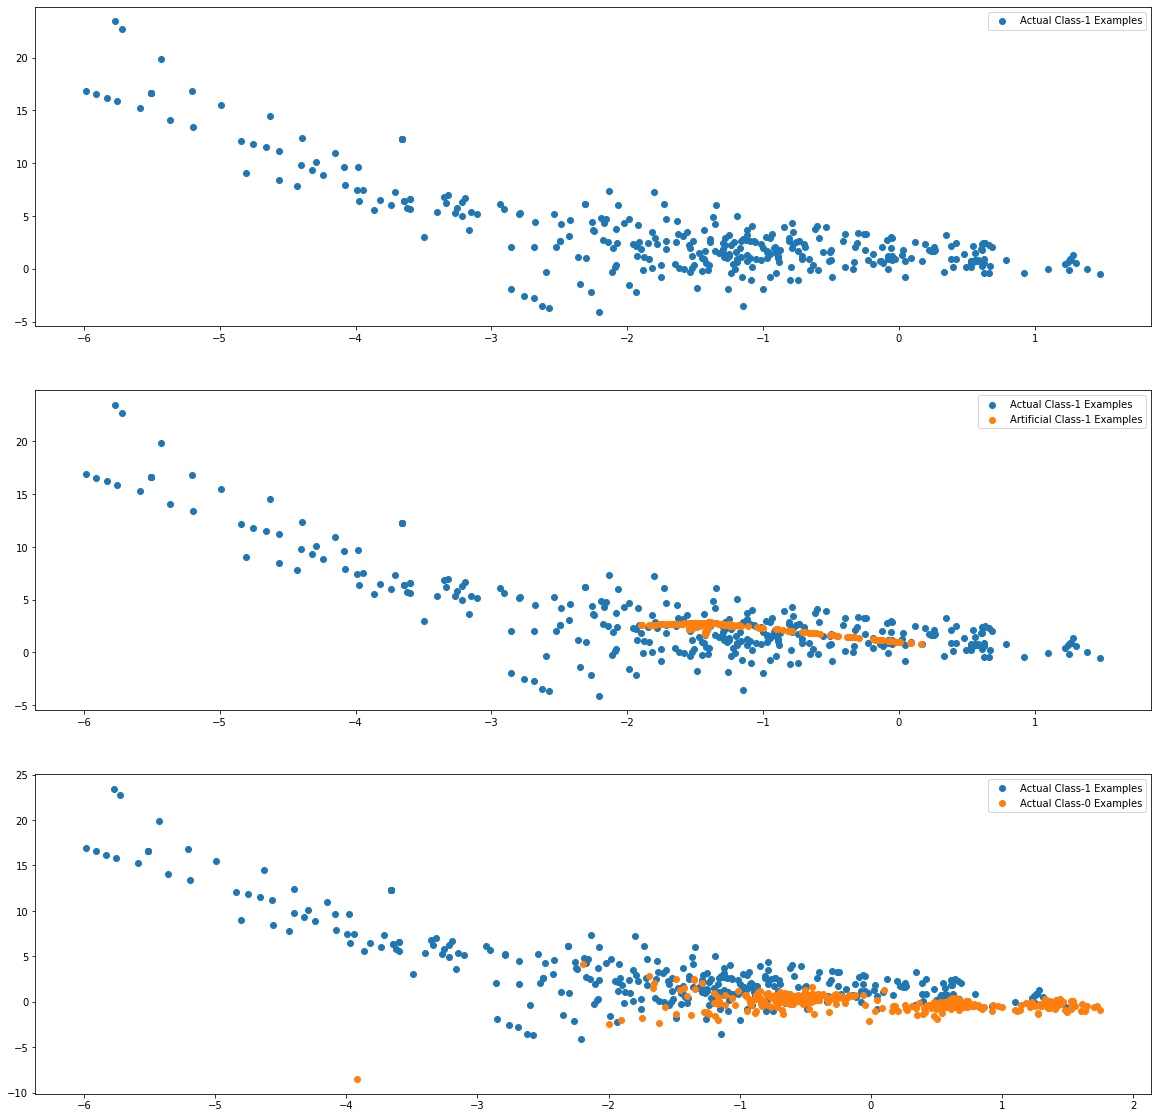

In [24]:
print_class_distribution(X_train_transformed, y_train, X_train_transformed_over, y_train_over)

**Model 3 - XGBoost Classifier**

**Fix learning rate 0.1 and tune number of trees by fixing some tree parameters**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_8 = Pipeline([('over',ADASYN(random_state=100)), ('model',model)])
hyper_params = {'over__n_neighbors':range(3,8,1), 'model__n_estimators':range(50,201,50)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_8, hyper_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 146.7min finished


Best score:  0.9850894575234506
Best params:  {'model__n_estimators': 200, 'over__n_neighbors': 5}


**Trying higher number of estimators**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_8 = Pipeline([('over',ADASYN(random_state=100, n_neighbors=5)), ('model',model)])
hyper_params = {'model__n_estimators':range(250,401,50)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_8, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 64.9min finished


Best score:  0.9855914965856138
Best params:  {'model__n_estimators': 400}


In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, max_depth=8, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_8 = Pipeline([('over',ADASYN(random_state=100, n_neighbors=5)), ('model',model)])
hyper_params = {'model__n_estimators':range(450,601,50)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_8, hyper_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 91.0min finished


Best score:  0.9856122108305121
Best params:  {'model__n_estimators': 450}


**Tune max_depth and min_child_weight with n_estimators 450**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=450, gamma=0, subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_8 = Pipeline([('over',ADASYN(random_state=100, n_neighbors=5)), ('model',model)])
hyper_params = {'model__max_depth':range(5,10,2), 'model__min_child_weight':range(1,5,2)}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_8, hyper_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 115.5min finished


Best score:  0.9857564984022733
Best params:  {'model__max_depth': 9, 'model__min_child_weight': 1}


**Tune gamma**

In [0]:
model = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=450, max_depth=9, min_child_weight=1,subsample=0.8, colsample_bytree=0.8,
                      scale_pos_weight=1)
pipeline_xgb_8 = Pipeline([('over',ADASYN(random_state=100, n_neighbors=5)), ('model',model)])
hyper_params = {'model__gamma':[0,0.1,0.2,0.3,0.4,0.5]}

gridsearch_cv(np.array(X_train_transformed), np.array(y_train), pipeline_xgb_8, hyper_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 135.4min finished


Best score:  0.9857564984022733
Best params:  {'model__gamma': 0}


**Building a final model with tuned parameters**

In [0]:
sampler = ADASYN(random_state=100, n_neighbors=5)
X_train_transformed_over, y_train_over = sampler.fit_resample(X_train_transformed, y_train)

xgb_8 = XGBClassifier(random_state=100, learning_rate=0.1, n_estimators=450, max_depth=9, min_child_weight=1, gamma=0,
                      subsample=0.8,colsample_bytree=0.8, scale_pos_weight=1, reg_alpha=0, reg_lambda=1)

xgb_8 = xgb_8.fit(np.array(X_train_transformed_over), np.array(y_train_over))

y_test_pred = xgb_8.predict(np.array(X_test_transformed))
print ("roc_auc_score: ", roc_auc_score(y_test, y_test_pred))
print ("sensitivity: ", recall_score(y_test, y_test_pred))

roc_auc_score:  0.915370542299143
sensitivity:  0.831081081081081


## **Conclusion: Using balancing technique - ADASYN, below is the test roc auc score for different models in decreasing order of the score:**
**Logistic Regression: 0.9222<br>
SVM with linear kernel: 0.9171 <br>
XGboost Classifier: 0.9153<br>**

##**Out of 3 sampling techniques, model and technique that gives best score is-<br>SVM with Linear kernel with SMOTE over-sampling technique giving an roc-auc score of 0.9344**

**Important features of final model svm_7 is:**

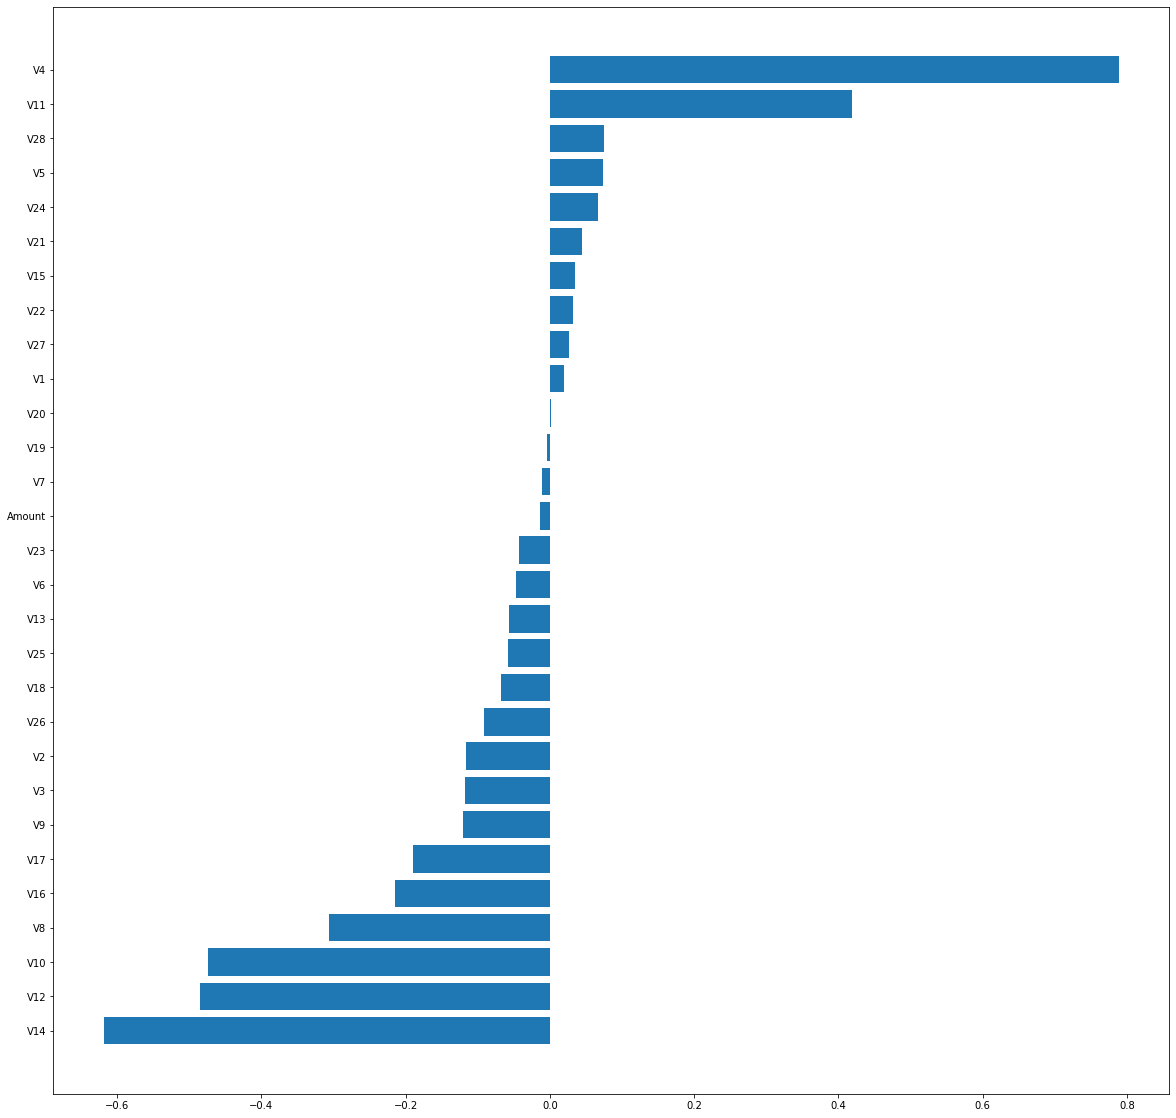

In [35]:
features = X_train.columns.to_list()
important_coefficients = svm_7.coef_.flatten()

important_coefficients, features = zip(*sorted(zip(important_coefficients, features)))
plt.barh(range(len(features)), important_coefficients, align='center')
plt.yticks(range(len(features)), features)
plt.show()